In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from fancyimpute import IterativeImputer
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [14]:
url = "https://raw.githubusercontent.com/d-ev-craig/DATA621_Group/main/HW5/data/wine-training-data.csv"
data = pd.read_csv(url)
# drop index
data = data.drop(data.columns[0], axis=1)

In [15]:
# Data Summary
data.describe()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
count,12795.000000,12795.000000,12795.000000,12795.000000,12179.000000,12157.000000,12148.000000,12113.000000,12795.000000,12400.000000,11585.000000,12142.000000,12795.000000,12795.000000,9436.000000
mean,3.029074,7.075717,0.324104,0.308413,5.418733,0.054822,30.845571,120.714233,0.994203,3.207628,0.527112,10.489236,-0.009066,7.772724,2.041755
std,1.926368,6.317643,0.784014,0.862080,33.749379,0.318467,148.714558,231.913211,0.026538,0.679687,0.932129,3.727819,0.891089,1.323926,0.902540
min,0.000000,-18.100000,-2.790000,-3.240000,-127.800000,-1.171000,-555.000000,-823.000000,0.888090,0.480000,-3.130000,-4.700000,-2.000000,4.000000,1.000000
25%,2.000000,5.200000,0.130000,0.030000,-2.000000,-0.031000,0.000000,27.000000,0.987720,2.960000,0.280000,9.000000,-1.000000,7.000000,1.000000
50%,3.000000,6.900000,0.280000,0.310000,3.900000,0.046000,30.000000,123.000000,0.994490,3.200000,0.500000,10.400000,0.000000,8.000000,2.000000
75%,4.000000,9.500000,0.640000,0.580000,15.900000,0.153000,70.000000,208.000000,1.000515,3.470000,0.860000,12.400000,1.000000,8.000000,3.000000
max,8.000000,34.400000,3.680000,3.860000,141.150000,1.351000,623.000000,1057.000000,1.099240,6.130000,4.240000,26.500000,2.000000,17.000000,4.000000


A quick look at the variables 5 number summary reveals that several variables have large ranges which when relating to their mean may suggest significantly different scales between variables, a high amount of skew, bi-modal distributions, or outliers. FixedAcidity, ResidualSugar, FreeSulfurDioxide, and TotalSulfurDioxide have fairly extreme ranges in comparison to their means.  Variables with Kurtosis greater than 4 will have observations distributed into heavy or long tails and may suggest numerous outliers, less than 2 suggest distributions centered around their mean with short or thin tails. Many of the variables are just below 2 suggesting many will have sharp peaks around the mean. Only AcidIndex shows as a non-ordinal or discrete distribution with extreme values of kurtosis, suggesting it will contain many outliers. 


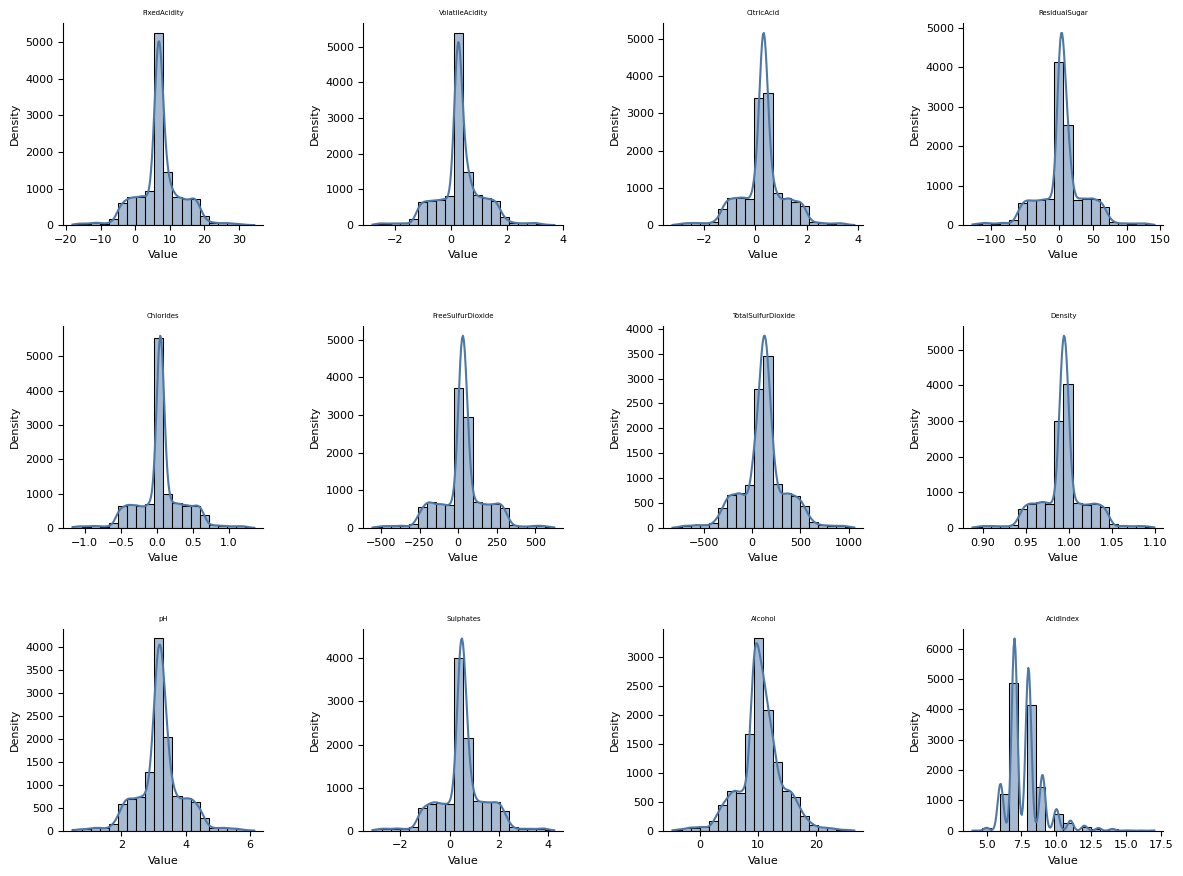

In [16]:
# Select columns and reshape data
data_melted = data.drop(columns=['LabelAppeal', 'STARS', 'TARGET']).melt(var_name='variable', value_name='value')

# Create the plot
g = sns.FacetGrid(data_melted, col="variable", col_wrap=4, sharex=False, sharey=False)

g.map(sns.histplot, "value", kde=True, bins=20, color='#4E79A7', edgecolor='black')

# Customizing the plot
for ax in g.axes.flat:
    ax.title.set_size(5)
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)

g.set_titles(col_template="{col_name}", size=5)
g.fig.subplots_adjust(hspace=0.5, wspace=0.5)
g.set(xlabel='Value', ylabel='Density')

plt.show()


As kurtosis foreshadowed, many of the distributions have sharp peaks at the mean with only the AcidIndex showing a bi-modal distribution. With the sharp centers around the peaks in the histograms, a high number of outliers may present themselves.


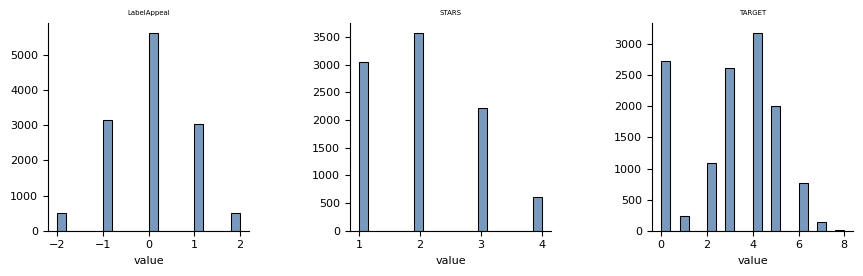

In [17]:
data_melted = data[['LabelAppeal', 'STARS', 'TARGET']].melt(var_name='variable', value_name='value')

# Create the plot
g = sns.FacetGrid(data_melted, col="variable", col_wrap=3, sharex=False, sharey=False)

g.map(sns.histplot, "value", bins=20, color='#4E79A7', edgecolor='black')

# Customize the plot
for ax in g.axes.flat:
    ax.title.set_size(5)
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel("", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)

g.set_titles(col_template="{col_name}", size=5)
g.fig.subplots_adjust(hspace=0.5, wspace=0.5)
g.set(ylabel='')

plt.show()


There is a relatively normal distribution to LabelAppeal, but both STARS and TARGET tend to favor their lower values suggesting it's quite difficult to gain either a critic's praise or a significant amount of cases sold.


c:\Users\shaya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


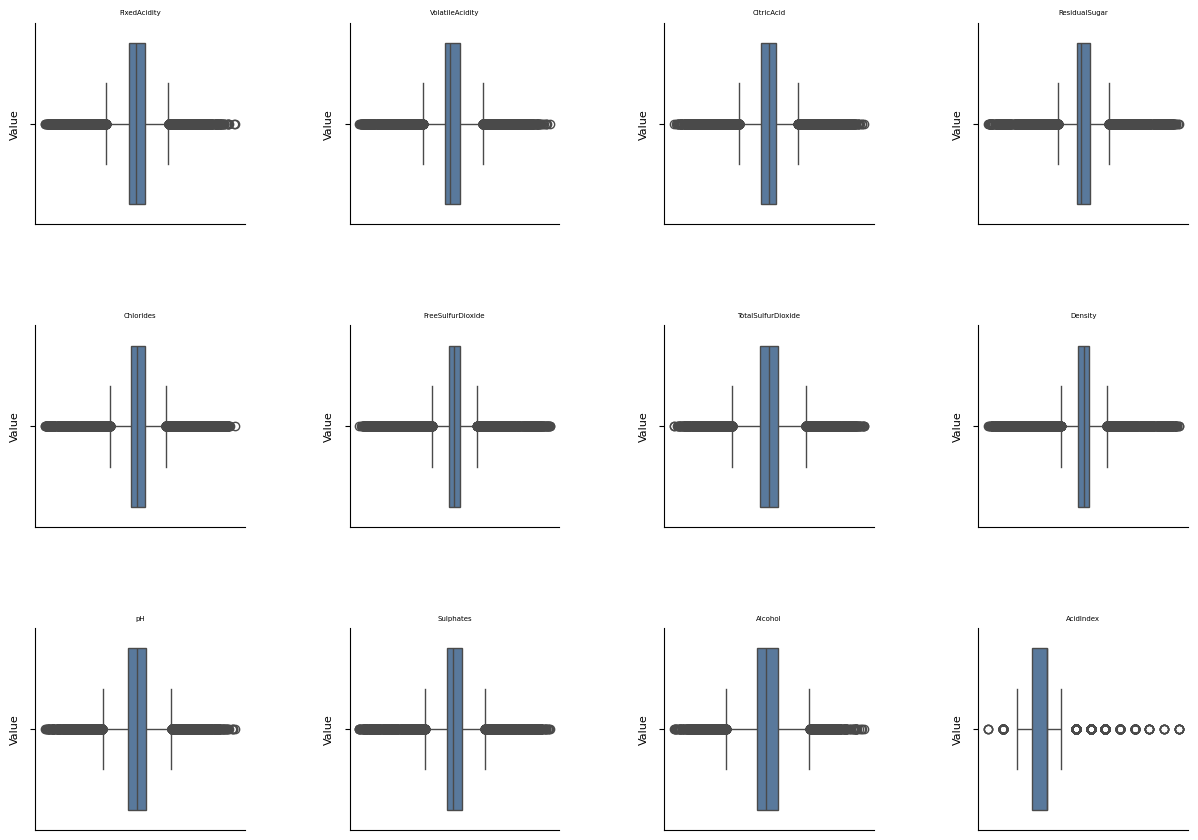

In [18]:
# Select the columns and reshape the data
data_melted = data.drop(columns=['LabelAppeal', 'STARS', 'TARGET']).melt(var_name='Variable', value_name='Value')

# Create the box plot
g = sns.FacetGrid(data_melted, col="Variable", col_wrap=4, sharex=False, sharey=False)

g.map(sns.boxplot, "Value", color="#4E79A7")

# Customize the plot
for ax in g.axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("Value", fontsize=8)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.title.set_size(5)

g.set_titles(col_template="{col_name}", size=5)
g.fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()


Boxplots reveal a significant number of residuals in all of the variables.

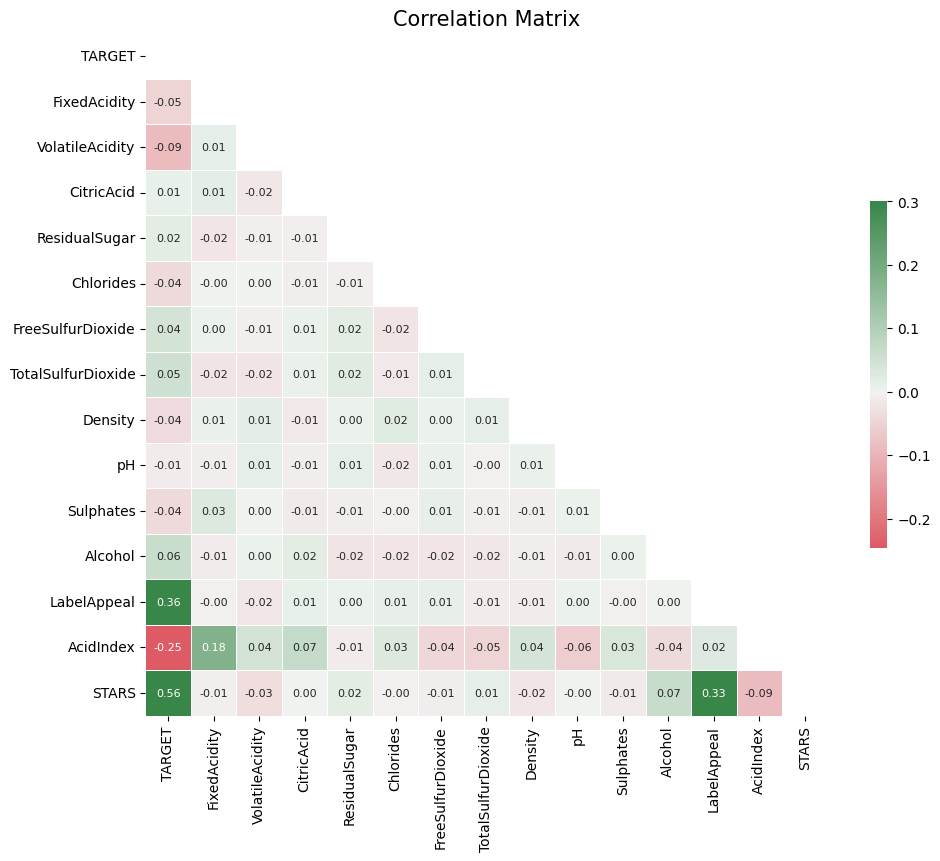

In [19]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Define a custom diverging colormap
cmap = sns.diverging_palette(10, 133, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
            annot_kws={"size": 8}, linecolor='white')

# Customize plot
plt.title('Correlation Matrix', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


The correlation matrix reveals a moderate relationship between STARS and LabelAppeal with Target. Although both STARS and LabelAppeal seem to be somewhat correlated to each other suggesting potential colinearity. The AcidIndex, being a propietary method that aggregates across Acid metrics, does show some relationship with FixedAcidity but is relatively minor.

C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\3730145822.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pMiss', y='variables', data=pMiss, palette=["#4E79A7"], edgecolor='black')
C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\3730145822.py:14: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='pMiss', y='variables', data=pMiss, palette=["#4E79A7"], edgecolor='black')


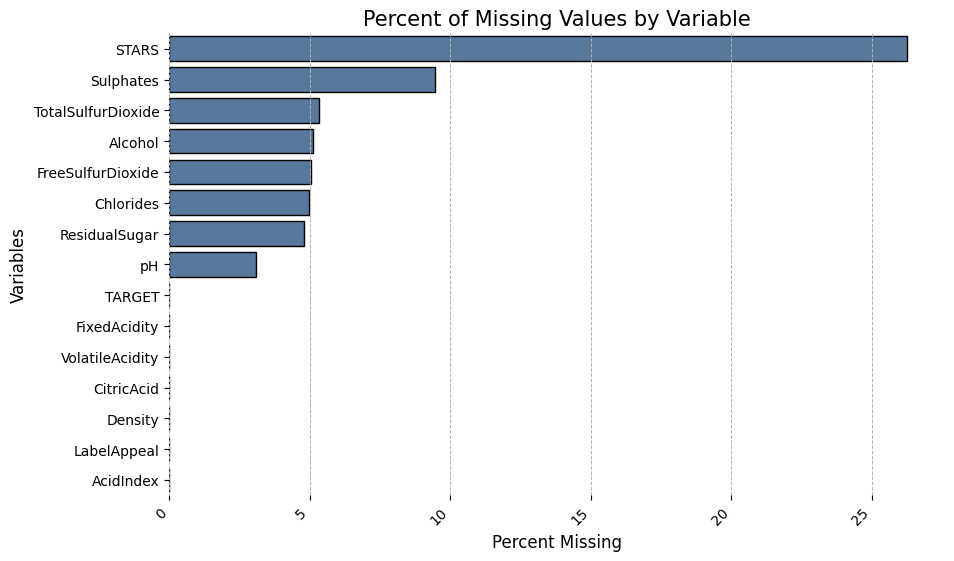

In [20]:
# Function to calculate the percentage of missing values
def percent_miss(x):
    return (x.isnull().sum() / len(x)) * 100

# Calculate the percentage of missing values for variables (columns)
variable_pMiss = data.apply(percent_miss)

# Convert to DataFrame and sort by percentage of missing values
pMiss = pd.DataFrame({'variables': variable_pMiss.index, 'pMiss': variable_pMiss.values})
pMiss = pMiss.sort_values(by='pMiss', ascending=False)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='pMiss', y='variables', data=pMiss, palette=["#4E79A7"], edgecolor='black')

# Customize the plot
plt.xlabel('Percent Missing', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.title('Percent of Missing Values by Variable', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', linewidth=0.7)
sns.despine(left=True, bottom=True)

plt.show()


While missing values may be indicative of the target, the STARS variable is missing 26% of its values. Determining the relationship it has to cases sold may be useful before removing it from the dataset. To view the relationship of the "missing" STARS ratings, NA's have been replaced with a category of "Unrated" and the bar plots are shown again. Chlorides, FreeSulfurDioxide, Alcohol, and TotalSulfurDioxide are missing around 5% or about 600 values. Sulphates is missing about 10% of its values and about 1200 values.


In [21]:
# Summarise missing values
missing_val = data.isnull().sum().reset_index()
missing_val.columns = ['Variable', 'MissingValues']
missing_val = missing_val[missing_val['MissingValues'] != 0]

# Display the missing values count
print(tabulate(missing_val, headers='keys', tablefmt='fancy_grid', showindex=False))


╒════════════════════╤═════════════════╕
│ Variable           │   MissingValues │
╞════════════════════╪═════════════════╡
│ ResidualSugar      │             616 │
├────────────────────┼─────────────────┤
│ Chlorides          │             638 │
├────────────────────┼─────────────────┤
│ FreeSulfurDioxide  │             647 │
├────────────────────┼─────────────────┤
│ TotalSulfurDioxide │             682 │
├────────────────────┼─────────────────┤
│ pH                 │             395 │
├────────────────────┼─────────────────┤
│ Sulphates          │            1210 │
├────────────────────┼─────────────────┤
│ Alcohol            │             653 │
├────────────────────┼─────────────────┤
│ STARS              │            3359 │
╘════════════════════╧═════════════════╛


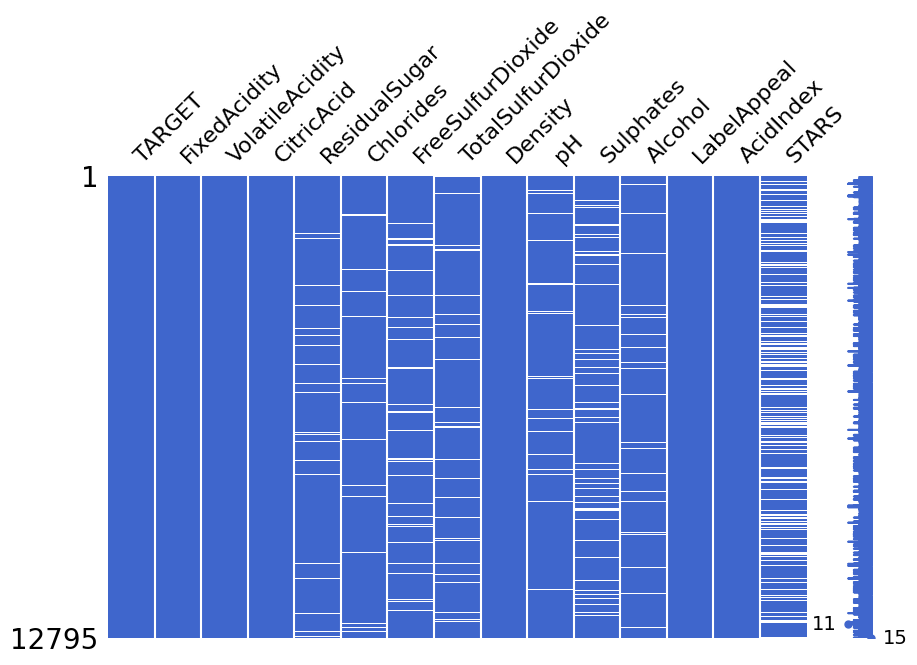

In [22]:
# Plot missing data pattern
msno.matrix(data, figsize=(10, 6), color=(0.25, 0.4, 0.8))

# Display the plot
plt.show()

While unrated wines typically aren't purchased, there are some that sell about 3 cases. This might suggest that non-rated wines are not submitted for critic's appraisal and should be used as a feature in the modeling. This plot also reveals a heavy preference for 2 star wines.

C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\743403585.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unrated' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data['STARS'].fillna('Unrated', inplace=True)
C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\743403585.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\743403585.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\743403585.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i

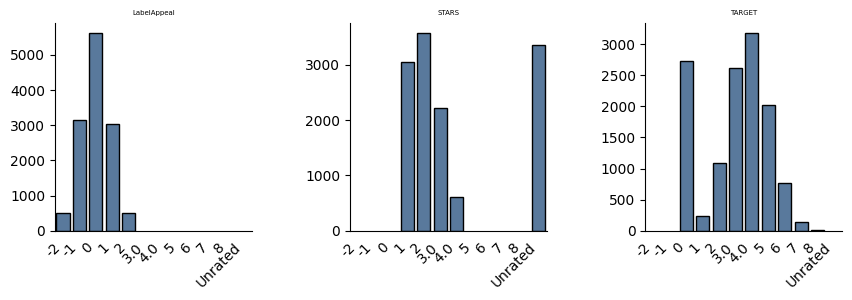

In [23]:
# Replace missing values in 'STARS' with 'Unrated'
data['STARS'].fillna('Unrated', inplace=True)

# Convert columns to categorical types
data['STARS'] = data['STARS'].astype('category')
data['TARGET'] = data['TARGET'].astype('category')
data['LabelAppeal'] = data['LabelAppeal'].astype('category')

# Select the relevant columns and reshape the data
data_melted = data[['LabelAppeal', 'STARS', 'TARGET']].melt(var_name='variable', value_name='value')

# Convert the 'value' column to category
data_melted['value'] = data_melted['value'].astype('category')

# Create the bar plot
g = sns.FacetGrid(data_melted, col="variable", col_wrap=3, sharex=False, sharey=False)

g.map(sns.countplot, "value", order=data_melted['value'].cat.categories, color='#4E79A7', edgecolor='black')

# Customize the plot
for ax in g.axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.title.set_size(5)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

g.set_titles(col_template="{col_name}", size=5)
g.fig.subplots_adjust(hspace=0.5, wspace=0.5)
g.set(ylabel='')

plt.show()

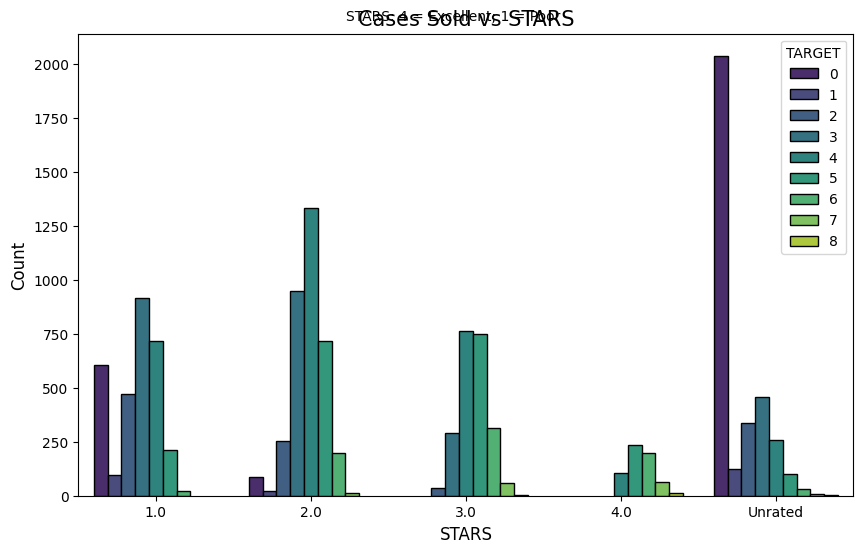

In [24]:
# Replace missing values in 'STARS' with 'Unrated'
data['STARS'].fillna('Unrated', inplace=True)

# Convert columns to categorical types
data['STARS'] = data['STARS'].astype('category')
data['TARGET'] = data['TARGET'].astype('category')
data['LabelAppeal'] = data['LabelAppeal'].astype('category')

# Create the plot
plt.figure(figsize=(10, 6))
bin_plot = sns.countplot(data=data, x='STARS', hue='TARGET', palette='viridis', edgecolor='black')

# Customize the plot
bin_plot.set_title("Cases Sold vs STARS", fontsize=15)
bin_plot.set_xlabel("STARS", fontsize=12)
bin_plot.set_ylabel("Count", fontsize=12)
bin_plot.legend(title='TARGET')
plt.suptitle('STARS: 4 = Excellent; 1 = Poor', fontsize=10, y=0.92)

plt.show()



The majority of 0 value appeals center on 4 cases sold and does tend to show a linear relationship between the two.

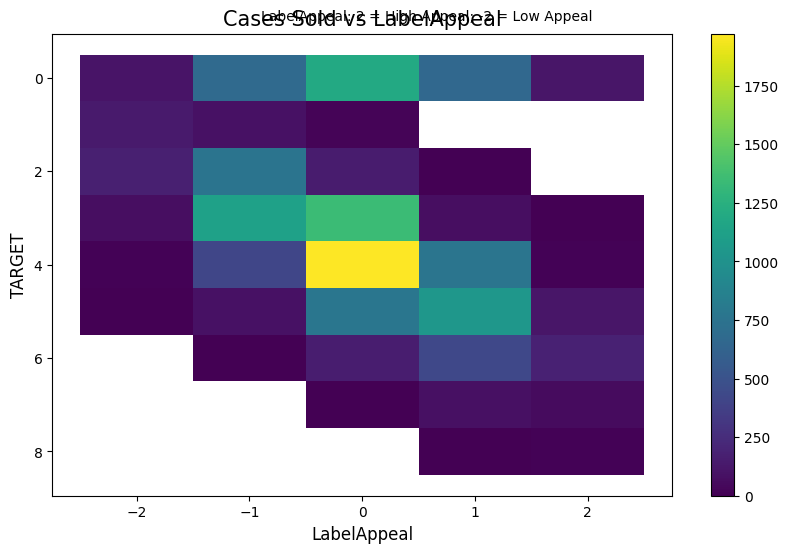

In [25]:
# Convert columns to categorical types if needed
data['TARGET'] = data['TARGET'].astype('category')
data['LabelAppeal'] = data['LabelAppeal'].astype('category')

# Create the plot
plt.figure(figsize=(10, 6))
bin_plot = sns.histplot(data=data, x='LabelAppeal', y='TARGET', bins=30, cbar=True, cmap='viridis')

# Customize the plot
bin_plot.set_title("Cases Sold vs LabelAppeal", fontsize=15)
bin_plot.set_xlabel("LabelAppeal", fontsize=12)
bin_plot.set_ylabel("TARGET", fontsize=12)
plt.suptitle('LabelAppeal: 2 = High Appeal; -2 = Low Appeal', fontsize=10, y=0.92)

plt.show()

# Data Preparation

Now that we have explored our data set, we can move on to data preparation to prep out data for modeling and analysis. 

## Data Wrangling

To do list:
1. Split the data into training and testing sets
2. Impute missing values
3. Normalize the data
4. Deal with outliers 
5. One hot encode the categorical variables



The data has already been partially cleaned with the removal of the INDEX variable. The missing values in STARS were replaced with "Unrated" to indicate non-rated wines.

In [26]:
# Set seed for reproducibility
random_seed = 1125

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, stratify=data['TARGET'], random_state=random_seed)

# Display the shapes of the resulting datasets
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (8956, 15)
Testing data shape: (3839, 15)


In [27]:


# Split train and test data
train_data, test_data = train_test_split(data, test_size=0.3, stratify=data['TARGET'], random_state=1125)

# Remove 'TARGET' column from the datasets
train_data_no_target = train_data.drop(columns=['TARGET'])
test_data_no_target = test_data.drop(columns=['TARGET'])

# Combine datasets for imputation
combined_data = pd.concat([train_data_no_target, test_data_no_target], axis=0)

# Separate numerical and categorical columns
num_cols = combined_data.select_dtypes(include=[np.number]).columns
cat_cols = combined_data.select_dtypes(exclude=[np.number]).columns

# Function to perform imputation
def impute_func(num_data, cat_data):
    # Impute numerical data
    num_imputer = IterativeImputer(max_iter=30, random_state=500)
    num_imputed = num_imputer.fit_transform(num_data)

    # Impute categorical data
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputed = cat_imputer.fit_transform(cat_data)
    
    # Combine imputed numerical and categorical data
    imputed_data = pd.DataFrame(np.hstack([num_imputed, cat_imputed]), columns=num_cols.tolist() + cat_cols.tolist())
    
    return num_imputer, cat_imputer, imputed_data

# Perform imputation
num_imputer, cat_imputer, imputed_data = impute_func(combined_data[num_cols], combined_data[cat_cols])

# Function to reintegrate target columns
def reintegrate_targets(imputed_data, original_data, target_vars):
    if not all(var in original_data.columns for var in target_vars):
        raise ValueError("Target variables not found in the original data")
    targets = original_data[target_vars].reset_index(drop=True)
    imputed_data_with_targets = pd.concat([imputed_data, targets], axis=1)
    return imputed_data_with_targets

# Combine original data
full_combined_data = pd.concat([train_data, test_data], axis=0)

# Reintegrate targets
imputed_data_with_targets = reintegrate_targets(imputed_data, full_combined_data, ['TARGET'])

# Separate the imputed data back into train and test sets
train_data_imputed = imputed_data_with_targets[:len(train_data)].reset_index(drop=True)
test_data_imputed = imputed_data_with_targets[len(train_data):].reset_index(drop=True)

# Drop unnecessary columns
train_data_imputed = train_data_imputed.drop(columns=['.imp', '.id'], errors='ignore')
test_data_imputed = test_data_imputed.drop(columns=['.imp', '.id'], errors='ignore')

# Display the resulting data
print("Train Data Imputed:\n", train_data_imputed.head())
print("\nTest Data Imputed:\n", test_data_imputed.head())


Train Data Imputed:
   FixedAcidity VolatileAcidity CitricAcid ResidualSugar Chlorides  \
0          7.1            0.73       2.45       5.41511     0.236   
1          5.2           -0.44      -1.14           2.5     0.077   
2          7.0            0.22      -0.56         -46.0     0.041   
3          6.8            -0.8        0.3          42.7     0.043   
4          6.9            0.77       1.34          26.6     0.045   

  FreeSulfurDioxide TotalSulfurDioxide  Density    pH Sulphates Alcohol  \
0              35.0              115.0  0.98665  2.45      1.88    13.5   
1               6.0               14.0  0.97069  2.71      0.18    11.0   
2             263.0              -55.0  1.00359  2.37      2.26    10.5   
3              65.0               95.0  0.95864  2.79      0.46     7.3   
4              54.0              190.0  0.99595  2.04     -0.36     3.4   

  AcidIndex LabelAppeal    STARS TARGET  
0       8.0           1      2.0      6  
1       7.0           1      

Now that we've imputed the missing values, we can compare the summary statistics of the original data and the imputed data. The summary statistics are calculated for the following variables: Chlorides, FreeSulfurDioxide, Alcohol, TotalSulfurDioxide, pH, and Sulphates. The summary statistics are calculated for the full training data set, the training data set after imputation, and the testing data set after imputation. The summary statistics are calculated for the minimum, 1st quartile, median, mean, 3rd quartile, and maximum values of the variables. The summary statistics are then compared across the three data sets to see how the imputation process has affected the data.

In [28]:
# Function to generate summary statistics
def generate_summary(data, vars, dataset_name):
    summary_stats = data[vars].describe(percentiles=[.25, .5, .75]).transpose()
    summary_stats['Dataset'] = dataset_name
    summary_stats = summary_stats.reset_index().rename(columns={'index': 'Variable'})
    summary_stats = summary_stats.melt(id_vars=['Variable', 'Dataset'], var_name='Statistic', value_name='Value')
    return summary_stats

# Define variables
variables = ["Chlorides", "FreeSulfurDioxide", "Alcohol", "TotalSulfurDioxide", "pH", "Sulphates"]

# Generate summaries for each dataset
summary_full_train = generate_summary(train_data, variables, "Dataset (Pre-Imputations)")
summary_train_imputed = generate_summary(train_data_imputed, variables, "Train Imputed")
summary_test_imputed = generate_summary(test_data_imputed, variables, "Test Imputed")

# Combine the summaries
combined_summary = pd.concat([summary_full_train, summary_train_imputed, summary_test_imputed])

# Pivot the data wide for easier comparison
final_summary = combined_summary.pivot_table(index=['Variable', 'Statistic'], columns='Dataset', values='Value').reset_index()
final_summary = final_summary.applymap(lambda x: '{:.6f}'.format(x) if isinstance(x, (int, float)) else x)

# Display the table
print(tabulate(final_summary, headers='keys', tablefmt='fancy_grid'))

╒════╤════════════════════╤═════════════╤═════════════════════════════╤════════════════╤═════════════════╕
│    │ Variable           │ Statistic   │   Dataset (Pre-Imputations) │   Test Imputed │   Train Imputed │
╞════╪════════════════════╪═════════════╪═════════════════════════════╪════════════════╪═════════════════╡
│  0 │ Alcohol            │ 25%         │                    9        │        nan     │          nan    │
├────┼────────────────────┼─────────────┼─────────────────────────────┼────────────────┼─────────────────┤
│  1 │ Alcohol            │ 50%         │                   10.3      │        nan     │          nan    │
├────┼────────────────────┼─────────────┼─────────────────────────────┼────────────────┼─────────────────┤
│  2 │ Alcohol            │ 75%         │                   12.3      │        nan     │          nan    │
├────┼────────────────────┼─────────────┼─────────────────────────────┼────────────────┼─────────────────┤
│  3 │ Alcohol            │ count    

C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\1355632800.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_summary = final_summary.applymap(lambda x: '{:.6f}'.format(x) if isinstance(x, (int, float)) else x)


The above table is very encouraging. The summary statistics for the variables with missing data did not seem to change much after the imputation. Most of the discrepancies appear in the test data set, this plausibly due to the smaller sample size.

### Transformations

In [29]:
# Define the variables
variables = ["FixedAcidity", "VolatileAcidity", "CitricAcid", "ResidualSugar", "Chlorides", 
             "FreeSulfurDioxide", "TotalSulfurDioxide", "Density", "pH", "Sulphates", 
             "Alcohol", "AcidIndex"]

# Function to apply the best normalization transformation
def apply_best_normalize(data, variables):
    results = []

    for var in variables:
        # Drop NA values and convert to numpy array, ensuring numeric dtype
        original_data = pd.to_numeric(data[var], errors='coerce').dropna().values
        
        # Ensure all transformations result in numeric data
        transformations = {
            'None': original_data,
            'Z-Score': StandardScaler().fit_transform(original_data.reshape(-1, 1)).flatten(),
            'Min-Max': MinMaxScaler().fit_transform(original_data.reshape(-1, 1)).flatten(),
            'Log': np.log1p(original_data) if np.all(original_data > 0) else None
        }
        
        best_method = None
        lowest_skewness = float('inf')
        
        for method, transformed_data in transformations.items():
            if transformed_data is not None:
                current_skewness = abs(skew(transformed_data))
                if current_skewness < lowest_skewness:
                    lowest_skewness = current_skewness
                    best_method = method
        
        results.append({'Variable': var, 'Transformation': best_method})
    
    return pd.DataFrame(results)


# Apply the function to train_data_imputed
BN_results_train = apply_best_normalize(train_data_imputed, variables)

# Display the results using tabulate
print(tabulate(BN_results_train, headers='keys', tablefmt='fancy_grid'))

╒════╤════════════════════╤══════════════════╕
│    │ Variable           │ Transformation   │
╞════╪════════════════════╪══════════════════╡
│  0 │ FixedAcidity       │ Z-Score          │
├────┼────────────────────┼──────────────────┤
│  1 │ VolatileAcidity    │ None             │
├────┼────────────────────┼──────────────────┤
│  2 │ CitricAcid         │ Z-Score          │
├────┼────────────────────┼──────────────────┤
│  3 │ ResidualSugar      │ Z-Score          │
├────┼────────────────────┼──────────────────┤
│  4 │ Chlorides          │ Min-Max          │
├────┼────────────────────┼──────────────────┤
│  5 │ FreeSulfurDioxide  │ Min-Max          │
├────┼────────────────────┼──────────────────┤
│  6 │ TotalSulfurDioxide │ Z-Score          │
├────┼────────────────────┼──────────────────┤
│  7 │ Density            │ None             │
├────┼────────────────────┼──────────────────┤
│  8 │ pH                 │ None             │
├────┼────────────────────┼──────────────────┤
│  9 │ Sulpha

Again, we must be quite careful to avoid data leakage, calculating the parameters for these transformations using only the training set, and then applying the transformations to our other sets using the same parameters. 

In [30]:
# Function to calculate transformations
def calculate_transformations(data):
    transforms = {
        'FixedAcidity': norm.fit(data['FixedAcidity']),
        'VolatileAcidity': norm.fit(data['VolatileAcidity']),
        'CitricAcid': norm.fit(data['CitricAcid']),
        'ResidualSugar': norm.fit(data['ResidualSugar']),
        'Chlorides': norm.fit(data['Chlorides']),
        'FreeSulfurDioxide': norm.fit(data['FreeSulfurDioxide']),
        'TotalSulfurDioxide': norm.fit(data['TotalSulfurDioxide']),
        'Density': norm.fit(data['Density']),
        'pH': norm.fit(data['pH']),
        'Sulphates': norm.fit(data['Sulphates']),
        'Alcohol': norm.fit(data['Alcohol']),
        'AcidIndex': norm.fit(data['AcidIndex'])
    }
    return transforms

# Function to apply pre-calculated transformations
def apply_pre_calculated_transformations(data, transforms):
    data = data.copy()
    data['FixedAcidity_transformed'] = norm.cdf(data['FixedAcidity'], *transforms['FixedAcidity'])
    data['VolatileAcidity_transformed'] = norm.cdf(data['VolatileAcidity'], *transforms['VolatileAcidity'])
    data['CitricAcid_transformed'] = norm.cdf(data['CitricAcid'], *transforms['CitricAcid'])
    data['ResidualSugar_transformed'] = norm.cdf(data['ResidualSugar'], *transforms['ResidualSugar'])
    data['Chlorides_transformed'] = norm.cdf(data['Chlorides'], *transforms['Chlorides'])
    data['FreeSulfurDioxide_transformed'] = norm.cdf(data['FreeSulfurDioxide'], *transforms['FreeSulfurDioxide'])
    data['TotalSulfurDioxide_transformed'] = norm.cdf(data['TotalSulfurDioxide'], *transforms['TotalSulfurDioxide'])
    data['Density_transformed'] = norm.cdf(data['Density'], *transforms['Density'])
    data['pH_transformed'] = norm.cdf(data['pH'], *transforms['pH'])
    data['Sulphates_transformed'] = norm.cdf(data['Sulphates'], *transforms['Sulphates'])
    data['Alcohol_transformed'] = norm.cdf(data['Alcohol'], *transforms['Alcohol'])
    data['AcidIndex_transformed'] = norm.cdf(data['AcidIndex'], *transforms['AcidIndex'])
    return data

# Convert numeric-like columns to numeric and retain non-numeric column
def preprocess_data(data, exclude_columns):
    # Exclude columns you don't want to convert
    numeric_data = data.drop(columns=exclude_columns)
    # Convert remaining columns to numeric
    numeric_data = numeric_data.apply(pd.to_numeric, errors='coerce')
    # Reattach excluded columns
    non_numeric_data = data[exclude_columns]
    processed_data = pd.concat([numeric_data, non_numeric_data], axis=1)
    return processed_data

# Specify the truly non-numeric column(s) you want to exclude
exclude_columns = ['STARS']  # Replace with the actual column name

# Preprocess train and test data
train_data_processed = preprocess_data(train_data_imputed, exclude_columns)
test_data_processed = preprocess_data(test_data_imputed, exclude_columns)

# Ensure the data is ready for transformations
transform_params = calculate_transformations(train_data_processed.drop(columns=exclude_columns))
train_data_transformed = apply_pre_calculated_transformations(
    train_data_processed.drop(columns=exclude_columns), transform_params
)
test_data_transformed = apply_pre_calculated_transformations(
    test_data_processed.drop(columns=exclude_columns), transform_params
)

# Reattach the non-numeric column(s) to the transformed datasets
train_data_transformed = pd.concat([train_data_transformed, train_data_processed[exclude_columns]], axis=1)
test_data_transformed = pd.concat([test_data_transformed, test_data_processed[exclude_columns]], axis=1)

# Display the transformed data
print("Transformed Training Data:\n", train_data_transformed.head())
print("\nTransformed Testing Data:\n", test_data_transformed.head())



Transformed Training Data:
    FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
0           7.1             0.73        2.45        5.41511      0.236   
1           5.2            -0.44       -1.14        2.50000      0.077   
2           7.0             0.22       -0.56      -46.00000      0.041   
3           6.8            -0.80        0.30       42.70000      0.043   
4           6.9             0.77        1.34       26.60000      0.045   

   FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  ...  \
0               35.0               115.0  0.98665  2.45       1.88  ...   
1                6.0                14.0  0.97069  2.71       0.18  ...   
2              263.0               -55.0  1.00359  2.37       2.26  ...   
3               65.0                95.0  0.95864  2.79       0.46  ...   
4               54.0               190.0  0.99595  2.04      -0.36  ...   

   ResidualSugar_transformed  Chlorides_transformed  \
0                   0

In [31]:
# Ensure all columns intended for skewness calculation are numeric
columns_to_convert = [
    "FixedAcidity", "VolatileAcidity", "CitricAcid", "ResidualSugar", "Chlorides",
    "FreeSulfurDioxide", "TotalSulfurDioxide", "Density", "pH", "Sulphates", "Alcohol", "AcidIndex"
]

# Convert to numeric and handle errors
train_data_imputed[columns_to_convert] = train_data_imputed[columns_to_convert].apply(
    pd.to_numeric, errors='coerce'
)

# Recalculate pre-transformation skewness
pre_trans_skew = train_data_imputed[columns_to_convert].apply(
    lambda x: skew(x.dropna())
)

pre_trans_skew = pd.DataFrame(pre_trans_skew, columns=["Pre-Transformation Skew"]).reset_index()
pre_trans_skew = pre_trans_skew.rename(columns={"index": "Variable"})

# Recalculate post-transformation skewness
transformed_columns = [
    "FixedAcidity_transformed", "VolatileAcidity_transformed", "CitricAcid_transformed", 
    "ResidualSugar_transformed", "Chlorides_transformed", "FreeSulfurDioxide_transformed", 
    "TotalSulfurDioxide_transformed", "Density_transformed", "pH_transformed", 
    "Sulphates_transformed", "Alcohol_transformed", "AcidIndex_transformed"
]

post_trans_skew = train_data_transformed[transformed_columns].apply(
    lambda x: skew(x.dropna())
)

post_trans_skew = pd.DataFrame(post_trans_skew, columns=["Post-Transformation Skew"]).reset_index()
post_trans_skew = post_trans_skew.rename(columns={"index": "Variable"})
post_trans_skew["Variable"] = post_trans_skew["Variable"].str.replace("_transformed", "")

# Merge pre- and post-transformation skewness
skewness_comparison = pd.merge(pre_trans_skew, post_trans_skew, on="Variable")

# Display the comparison
print(tabulate(skewness_comparison, headers='keys', tablefmt='fancy_grid', floatfmt=".3f"))


╒════╤════════════════════╤═══════════════════════════╤════════════════════════════╕
│    │ Variable           │   Pre-Transformation Skew │   Post-Transformation Skew │
╞════╪════════════════════╪═══════════════════════════╪════════════════════════════╡
│  0 │ FixedAcidity       │                    -0.049 │                      0.004 │
├────┼────────────────────┼───────────────────────────┼────────────────────────────┤
│  1 │ VolatileAcidity    │                     0.073 │                      0.024 │
├────┼────────────────────┼───────────────────────────┼────────────────────────────┤
│  2 │ CitricAcid         │                    -0.053 │                     -0.036 │
├────┼────────────────────┼───────────────────────────┼────────────────────────────┤
│  3 │ ResidualSugar      │                    -0.069 │                      0.003 │
├────┼────────────────────┼───────────────────────────┼────────────────────────────┤
│  4 │ Chlorides          │                     0.034 │          

The transformations almost completely got rid of any skew in our data. We can visualize this using by recreating the histograms with the transformed data.

C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\4257787357.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\4257787357.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\4257787357.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\shaya\AppData\Local\Temp\ipykernel_2232\4257787357.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickla

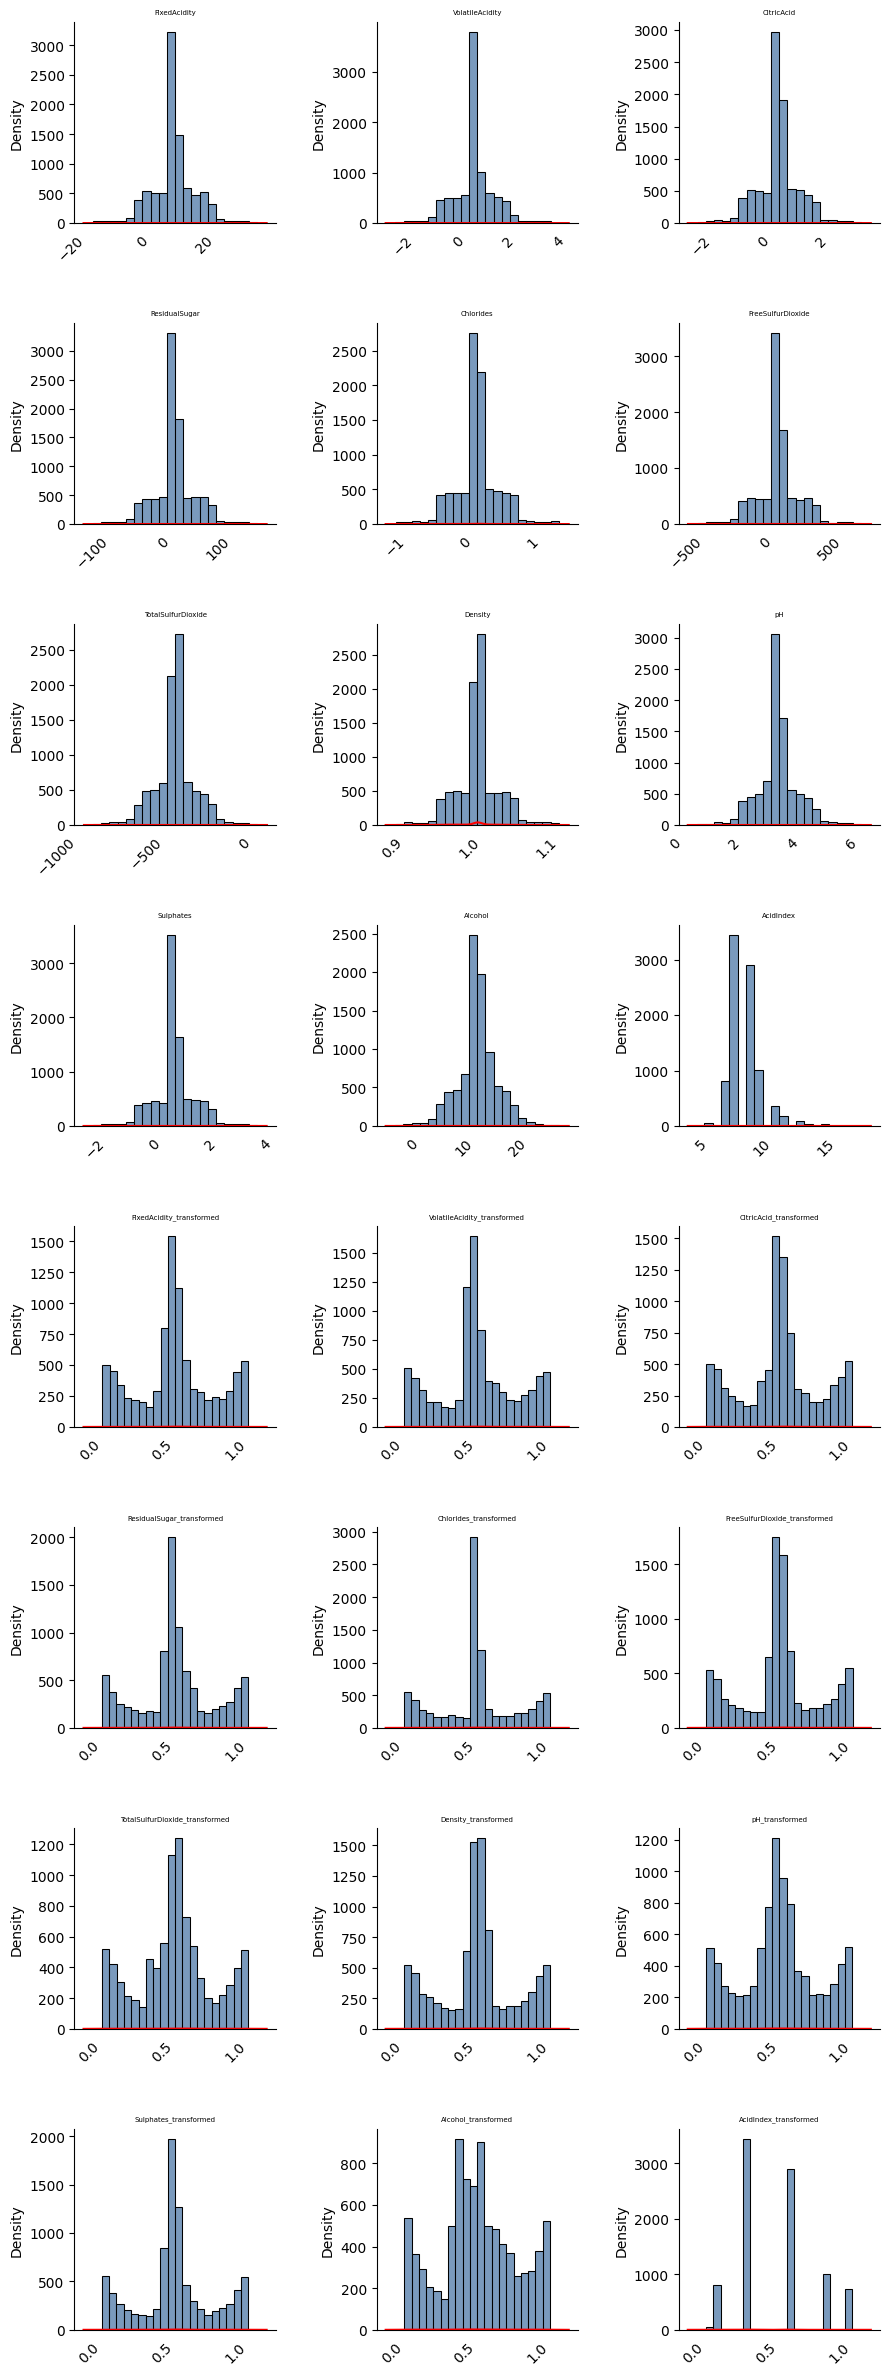

In [32]:
# Select relevant columns from the transformed training data
selected_columns = train_data_transformed.drop(columns=['LabelAppeal', 'STARS', 'TARGET'])

# Melt the dataframe to long format
melted_data = pd.melt(selected_columns, var_name='variable', value_name='value')

# Create the plot
g = sns.FacetGrid(melted_data, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, 'value', bins=20, color='#4E79A7', edgecolor='black')
g.map(sns.kdeplot, 'value', color='red')

# Customize the plot
for ax in g.axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("Density")
    ax.title.set_size(5)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

g.set_titles(col_template="{col_name}", size=5)
g.fig.subplots_adjust(hspace=0.5, wspace=0.5)
g.set(ylabel='Density')

plt.show()


Now that we've transformed our data, we can move on to dealing with outliers.

### Outliers

In [33]:
# Function to calculate outlier limits
def calc_outliers(data, columns):
    outlier_limits = {}
    for column in columns:
        Q1 = np.percentile(data[column].dropna(), 25)
        Q3 = np.percentile(data[column].dropna(), 75)
        IQR = Q3 - Q1
        outlier_limits[column] = {
            'lower': Q1 - 1.5 * IQR,
            'upper': Q3 + 1.5 * IQR
        }
    return outlier_limits

# Define the variables you want to check for outliers
variables = ["FixedAcidity", "VolatileAcidity", "CitricAcid", "ResidualSugar", "Chlorides", 
             "FreeSulfurDioxide", "TotalSulfurDioxide", "Density", "pH", "Sulphates", 
             "Alcohol", "AcidIndex"]

# Calculate outlier limits
limits = calc_outliers(train_data_transformed, variables)
limits


{'FixedAcidity': {'lower': -1.5000000000000009, 'upper': 16.1},
 'VolatileAcidity': {'lower': -0.645, 'upper': 1.395},
 'CitricAcid': {'lower': -0.835, 'upper': 1.4449999999999998},
 'ResidualSugar': {'lower': -20.4, 'upper': 36.4},
 'Chlorides': {'lower': -0.21000000000000002, 'upper': 0.334},
 'FreeSulfurDioxide': {'lower': -83.5, 'upper': 152.5},
 'TotalSulfurDioxide': {'lower': -213.0, 'upper': 443.0},
 'Density': {'lower': 0.9691675, 'upper': 1.0192275000000002},
 'pH': {'lower': 2.26, 'upper': 4.18},
 'Sulphates': {'lower': -0.305, 'upper': 1.415},
 'Alcohol': {'lower': 4.6, 'upper': 16.6},
 'AcidIndex': {'lower': 5.5, 'upper': 9.5}}

We will use the IQR method to detect outliers in the data. The IQR method is a robust method for detecting outliers that is not sensitive to the presence of extreme values. The IQR method defines an outlier as any value that is below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR. The lower and upper limits for each variable are calculated using the IQR method.

Using the IQR limits, there is a significant amount of outliers in the data. The transformation process did not impact the number of outliers in the data. Using a Box-Cox transformation might have been a better way to get rid of the outliers but it was not an option for many of the variables due to them containing negative and zero values.

In [34]:
# Function to calculate the percentage of outliers for each column
def calculate_outlier_percentage(data, limits):
    outlier_percentages = {}
    for column in limits.keys():
        lower_limit = limits[column]['lower']
        upper_limit = limits[column]['upper']
        outliers = ((data[column] < lower_limit) | (data[column] > upper_limit)).sum()
        total = data[column].notna().sum()
        percentage = (outliers / total) * 100
        outlier_percentages[column] = percentage
    return outlier_percentages

# Calculate outlier percentages using pre-calculated limits and the transformed dataset
outlier_percentages_transformed = calculate_outlier_percentage(train_data_transformed, limits)

# Calculate outlier percentages for the original dataset
outlier_percentages_original = calculate_outlier_percentage(train_data_imputed, limits)

# Create a data frame with outlier percentages for both datasets
outlier_comparison = pd.DataFrame({
    'Variable': list(outlier_percentages_transformed.keys()),
    'Original_Data': list(outlier_percentages_original.values()),
    'Transformed_Data': list(outlier_percentages_transformed.values())
})

# Display the comparison using tabulate
print(tabulate(outlier_comparison, headers='keys', tablefmt='fancy_grid', floatfmt=".3f"))

╒════╤════════════════════╤═════════════════╤════════════════════╕
│    │ Variable           │   Original_Data │   Transformed_Data │
╞════╪════════════════════╪═════════════════╪════════════════════╡
│  0 │ FixedAcidity       │          18.345 │             18.345 │
├────┼────────────────────┼─────────────────┼────────────────────┤
│  1 │ VolatileAcidity    │          20.433 │             20.433 │
├────┼────────────────────┼─────────────────┼────────────────────┤
│  2 │ CitricAcid         │          20.165 │             20.165 │
├────┼────────────────────┼─────────────────┼────────────────────┤
│  3 │ ResidualSugar      │          31.119 │             31.119 │
├────┼────────────────────┼─────────────────┼────────────────────┤
│  4 │ Chlorides          │          31.632 │             31.632 │
├────┼────────────────────┼─────────────────┼────────────────────┤
│  5 │ FreeSulfurDioxide  │          32.805 │             32.805 │
├────┼────────────────────┼─────────────────┼─────────────────

Ultimately, due to the large amount of outliers, removing them would result in a significant loss of data. We will keep the outliers in the data and move on to one-hot encoding the categorical variables.

### One-Hot Encoding

We have two factor columns in LabelAppeal and STARS. LabelAppeal can be converted to numeric as it is ordinal. While STARS is also ordinal, it also has an 'unrated' category. We will one-hot encode this column but also keep the original column for now.

In [35]:
# Define categorical columns
cat_cols = ["STARS"]

# Convert all values in the categorical columns to strings
train_data_transformed[cat_cols] = train_data_transformed[cat_cols].astype(str)
test_data_transformed[cat_cols] = test_data_transformed[cat_cols].astype(str)

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit the encoder on the training data and transform both training and test data
train_data_encoded = pd.DataFrame(encoder.fit_transform(train_data_transformed[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))
test_data_encoded = pd.DataFrame(encoder.transform(test_data_transformed[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))

# Bind the encoded columns to the original datasets
train_data_prepped = pd.concat([train_data_transformed.reset_index(drop=True), train_data_encoded], axis=1)
test_data_prepped = pd.concat([test_data_transformed.reset_index(drop=True), test_data_encoded], axis=1)

# Display the prepared data
print("Train Data Prepared:\n", train_data_prepped.head())
print("\nTest Data Prepared:\n", test_data_prepped.head())



Train Data Prepared:
    FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
0           7.1             0.73        2.45        5.41511      0.236   
1           5.2            -0.44       -1.14        2.50000      0.077   
2           7.0             0.22       -0.56      -46.00000      0.041   
3           6.8            -0.80        0.30       42.70000      0.043   
4           6.9             0.77        1.34       26.60000      0.045   

   FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  ...  \
0               35.0               115.0  0.98665  2.45       1.88  ...   
1                6.0                14.0  0.97069  2.71       0.18  ...   
2              263.0               -55.0  1.00359  2.37       2.26  ...   
3               65.0                95.0  0.95864  2.79       0.46  ...   
4               54.0               190.0  0.99595  2.04      -0.36  ...   

   Density_transformed  pH_transformed  Sulphates_transformed  \
0             0.3

In [36]:
# Define categorical columns
cat_cols = ["STARS"]

# Convert all values in the categorical columns to strings
train_data_imputed[cat_cols] = train_data_imputed[cat_cols].astype(str)
test_data_imputed[cat_cols] = test_data_imputed[cat_cols].astype(str)

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit the encoder on the training data and transform both training and test data
train_data_encoded = pd.DataFrame(encoder.fit_transform(train_data_imputed[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))
test_data_encoded = pd.DataFrame(encoder.transform(test_data_imputed[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))

# Bind the encoded columns to the original datasets
train_data_prepped = pd.concat([train_data_imputed.reset_index(drop=True), train_data_encoded], axis=1)
test_data_prepped = pd.concat([test_data_imputed.reset_index(drop=True), test_data_encoded], axis=1)

# Display the prepared data
print("Train Data Prepared:\n", train_data_prepped.head())
print("\nTest Data Prepared:\n", test_data_prepped.head())

Train Data Prepared:
    FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
0           7.1             0.73        2.45        5.41511      0.236   
1           5.2            -0.44       -1.14        2.50000      0.077   
2           7.0             0.22       -0.56      -46.00000      0.041   
3           6.8            -0.80        0.30       42.70000      0.043   
4           6.9             0.77        1.34       26.60000      0.045   

   FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  Alcohol  \
0               35.0               115.0  0.98665  2.45       1.88     13.5   
1                6.0                14.0  0.97069  2.71       0.18     11.0   
2              263.0               -55.0  1.00359  2.37       2.26     10.5   
3               65.0                95.0  0.95864  2.79       0.46      7.3   
4               54.0               190.0  0.99595  2.04      -0.36      3.4   

   AcidIndex LabelAppeal    STARS TARGET  STARS_2.0  STARS

### Modeling

With the data exploration and preparation out of the way, we will build different types of regression models to predict the number of cases of wine ordered by distributors. Again, the response variable is the *count* of cases, so it is appropriate to consider Poisson regression, negative binomial regression, and multiple linear regression. We will build models of each type with some commentary, and then we will consider more generally how the models compare to one another.

#### Poisson Regression

We first consider Poisson regression models. It's critical to note that Poisson models do not require normally distributed data, so leveraging transformed data is actually counter-productive. As such, the relevant dataframes are:

- `train_data_imputed`
- `test_data_imputed`

### Poisson Model 1

We start with a rather simple model, with all the variables along with a few more sophisticated variables:

1. `Alcohol * LabelAppeal`: In case these two variables have an especially strong combined effect.
2. `STARS * Alcohol`: Since high-quality wines with certain alcohol content might sell especially well.
3. `LabelAppeal * STARS`: In case people might be especially likely to buy visually appealing and highly rated wines.
4. `Alcohol^2`: As intuitively alcohol content doesn't have a strictly linear relationship with the target variable.


In [37]:
# Before we start, ensure the columns in the training and testing datasets match
print("Training Data Columns:\n", train_data_prepped.columns)
print("\nTesting Data Columns:\n", test_data_prepped.columns)

Training Data Columns:
 Index(['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'ResidualSugar',
       'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide', 'Density', 'pH',
       'Sulphates', 'Alcohol', 'AcidIndex', 'LabelAppeal', 'STARS', 'TARGET',
       'STARS_2.0', 'STARS_3.0', 'STARS_4.0', 'STARS_Unrated'],
      dtype='object')

Testing Data Columns:
 Index(['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'ResidualSugar',
       'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide', 'Density', 'pH',
       'Sulphates', 'Alcohol', 'AcidIndex', 'LabelAppeal', 'STARS', 'TARGET',
       'STARS_2.0', 'STARS_3.0', 'STARS_4.0', 'STARS_Unrated'],
      dtype='object')


In [38]:


# Ensure target variable is numeric
train_data_prepped['TARGET'] = train_data_prepped['TARGET'].astype(int)

# Define the model formula
formula = """
TARGET ~ Alcohol + I(Alcohol**2) + LabelAppeal + STARS + AcidIndex + Chlorides + CitricAcid +
          Density + FixedAcidity + FreeSulfurDioxide + ResidualSugar + Sulphates + 
          TotalSulfurDioxide + VolatileAcidity + pH + Alcohol:LabelAppeal + 
          STARS:Alcohol + LabelAppeal:STARS
"""

# Build the Poisson regression model
model_p_simple_1 = smf.glm(formula=formula, data=train_data_prepped, family=sm.families.Poisson()).fit()
print(model_p_simple_1.summary())

# Check for multicollinearity
def check_collinearity(model):
    variables = model.model.exog
    vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
    return pd.DataFrame({'VIF': vif}, index=model.model.exog_names).sort_values(by='VIF', ascending=False)

print(check_collinearity(model_p_simple_1))

# Build the model without problematic interactions
formula_2 = """
TARGET ~ Alcohol + I(Alcohol**2) + LabelAppeal + STARS + AcidIndex + Chlorides + CitricAcid +
          Density + FixedAcidity + FreeSulfurDioxide + ResidualSugar + Sulphates + 
          TotalSulfurDioxide + VolatileAcidity + pH + Alcohol:LabelAppeal + STARS:Alcohol
"""

model_p_simple_2 = smf.glm(formula=formula_2, data=train_data_prepped, family=sm.families.Poisson()).fit()
print(model_p_simple_2.summary())
print(check_collinearity(model_p_simple_2))

# Remove high correlation variables step-by-step
formula_3 = """
TARGET ~ Alcohol + I(Alcohol**2) + LabelAppeal + STARS + AcidIndex + Chlorides + CitricAcid +
          Density + FixedAcidity + FreeSulfurDioxide + ResidualSugar + Sulphates + 
          TotalSulfurDioxide + VolatileAcidity + pH + STARS:Alcohol
"""

model_p_simple_3 = smf.glm(formula=formula_3, data=train_data_prepped, family=sm.families.Poisson()).fit()
print(check_collinearity(model_p_simple_3))

# Further model simplifications
formula_4 = """
TARGET ~ Alcohol + I(Alcohol**2) + LabelAppeal + STARS + AcidIndex + Chlorides + CitricAcid +
          Density + FixedAcidity + FreeSulfurDioxide + ResidualSugar + Sulphates + 
          TotalSulfurDioxide + VolatileAcidity + pH
"""

model_p_simple_4 = smf.glm(formula=formula_4, data=train_data_prepped, family=sm.families.Poisson()).fit()
print(check_collinearity(model_p_simple_4))

# Further model simplifications by manual backwards elimination
formula_5 = """
TARGET ~ Alcohol + I(Alcohol**2) + LabelAppeal + STARS + AcidIndex + Chlorides + CitricAcid +
          Density + FreeSulfurDioxide + ResidualSugar + Sulphates + TotalSulfurDioxide + 
          VolatileAcidity + pH
"""
formula_6 = """
TARGET ~ Alcohol + I(Alcohol**2) + LabelAppeal + STARS + AcidIndex + Chlorides + Density +
          FreeSulfurDioxide + ResidualSugar + Sulphates + TotalSulfurDioxide + 
          VolatileAcidity + pH
"""

formula_final = """
TARGET ~ Alcohol + I(Alcohol**2) + LabelAppeal + STARS + AcidIndex + Chlorides + Density +
          FreeSulfurDioxide + Sulphates + TotalSulfurDioxide + VolatileAcidity + pH
"""

model_p_simple_5 = smf.glm(formula=formula_5, data=train_data_prepped, family=sm.families.Poisson()).fit()
model_p_simple_6 = smf.glm(formula=formula_6, data=train_data_prepped, family=sm.families.Poisson()).fit()
model_p_simple = smf.glm(formula=formula_final, data=train_data_prepped, family=sm.families.Poisson()).fit()

print(model_p_simple.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 TARGET   No. Observations:                 8956
Model:                            GLM   Df Residuals:                     8911
Model Family:                 Poisson   Df Model:                           44
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15907.
Date:                Thu, 19 Dec 2024   Deviance:                       9456.5
Time:                        13:26:50   Pearson chi2:                 8.08e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5185
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

c:\Users\shaya\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                            VIF
LabelAppeal[T.-1]:STARS[T.4.0]              inf
LabelAppeal[T.2]:STARS[T.4.0]               inf
STARS[T.4.0]                                inf
LabelAppeal[T.1]:STARS[T.4.0]               inf
LabelAppeal[T.0]:STARS[T.4.0]               inf
Intercept                           1779.212993
STARS[T.3.0]                         113.230607
LabelAppeal[T.0]                      84.244231
Alcohol:LabelAppeal[T.0]              70.669884
LabelAppeal[T.1]                      69.111633
LabelAppeal[T.-1]                     66.039173
STARS[T.2.0]                          64.854928
Alcohol:LabelAppeal[T.1]              53.543828
Alcohol:LabelAppeal[T.-1]             52.082838
LabelAppeal[T.0]:STARS[T.3.0]         51.975569
LabelAppeal[T.1]:STARS[T.3.0]         42.159481
STARS[T.Unrated]                      38.765983
Alcohol                               38.297919
LabelAppeal[T.0]:STARS[T.2.0]         31.423394
LabelAppeal[T.2]                      29

In [39]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure target variable is numeric
train_data_prepped['TARGET'] = train_data_prepped['TARGET'].astype(int)

# Replace NaN values with -1 for the entire DataFrame
train_data_prepped = train_data_prepped.fillna(-1)

# Ensure all columns are numeric
train_data_prepped = train_data_prepped.apply(pd.to_numeric, errors='coerce')

# Create transformed columns manually
train_data_prepped['Alcohol_squared'] = train_data_prepped['Alcohol'] ** 2
train_data_prepped['Alcohol_LabelAppeal_interaction'] = train_data_prepped['Alcohol'] * train_data_prepped['LabelAppeal']
train_data_prepped['STARS_Alcohol_interaction'] = train_data_prepped['STARS'] * train_data_prepped['Alcohol']

# Ensure categorical variables are dummified (e.g., LabelAppeal, STARS)
train_data_prepped = pd.get_dummies(train_data_prepped, drop_first=True)

# Build the Poisson regression model manually
formula = """
TARGET ~ Alcohol + Alcohol_squared + LabelAppeal + STARS + AcidIndex + Chlorides + CitricAcid +
          Density + FixedAcidity + FreeSulfurDioxide + ResidualSugar + Sulphates + 
          TotalSulfurDioxide + VolatileAcidity + pH + Alcohol_LabelAppeal_interaction + 
          STARS_Alcohol_interaction
"""

# Fit the Poisson model
model_p_simple = smf.glm(formula=formula, data=train_data_prepped, family=sm.families.Poisson()).fit()

# Print the model summary
print(model_p_simple.summary())

# Check for multicollinearity (Variance Inflation Factor)
def check_collinearity(model):
    variables = model.model.exog
    vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
    return pd.DataFrame({'VIF': vif}, index=model.model.exog_names).sort_values(by='VIF', ascending=False)

# Print the collinearity check
print(check_collinearity(model_p_simple))


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 TARGET   No. Observations:                 6626
Model:                            GLM   Df Residuals:                     6608
Model Family:                 Poisson   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11949.
Date:                Thu, 19 Dec 2024   Deviance:                       4225.9
Time:                        13:26:53   Pearson chi2:                 2.86e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2530
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure the target variable is numeric
test_data_prepped['TARGET'] = test_data_prepped['TARGET'].astype(int)

# Handle missing or infinite values in the target column
test_data_prepped['TARGET'] = test_data_prepped['TARGET'].fillna(-1)  # Fill NaNs with -1
test_data_prepped['TARGET'] = test_data_prepped['TARGET'].replace([np.inf, -np.inf], -1)  # Replace inf/-inf with -1

# Ensure the target variable is numeric (convert to integer)
test_data_prepped['TARGET'] = test_data_prepped['TARGET'].astype(int)

# Now proceed with your transformations and predictions

# Fill missing values for categorical columns with a placeholder (e.g., "missing")
#test_data_prepped[categorical_columns] = test_data_prepped[categorical_columns].fillna('missing')

# Fill missing values for numerical columns with -1
#test_data_prepped[numerical_columns] = test_data_prepped[numerical_columns].fillna(-1)

# Convert the columns to numeric values where necessary
test_data_prepped = test_data_prepped.apply(pd.to_numeric, errors='coerce')

# Create transformed columns manually
test_data_prepped['Alcohol_squared'] = test_data_prepped['Alcohol'] ** 2
test_data_prepped['Alcohol_LabelAppeal_interaction'] = test_data_prepped['Alcohol'] * test_data_prepped['LabelAppeal']
test_data_prepped['STARS_Alcohol_interaction'] = test_data_prepped['STARS'] * test_data_prepped['Alcohol']

# Ensure categorical variables are dummified (e.g., LabelAppeal, STARS)
test_data_prepped = pd.get_dummies(test_data_prepped, drop_first=True)

# Predict the target variable on the test data
test_data_prepped['TARGET'] = model_p_simple.predict(test_data_prepped)

# Check for NaN values in the predicted target
test_data_prepped['TARGET'] = test_data_prepped['TARGET'].fillna(-1)  # Ensure no NaNs in predictions

# Calculate MSE, MAE and r-squared
p_regression_mse = mean_squared_error(test_data['TARGET'], test_data_prepped['TARGET'])
p_regression_mae = mean_absolute_error(test_data['TARGET'], test_data_prepped['TARGET'])
p_regression_r2 = r2_score(test_data['TARGET'], test_data_prepped['TARGET'])


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Handle NaN values before standardizing features
train_data_prepped = train_data_prepped.fillna(0)
test_data_prepped = test_data_prepped.fillna(0)

# Standardize features
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data_prepped.drop(columns=['TARGET']))
test_data_scaled = scaler.transform(test_data_prepped.drop(columns=['TARGET']))
train_data_scaled = scaler.fit_transform(train_data_prepped.drop(columns=['TARGET']))
test_data_scaled = scaler.transform(test_data_prepped.drop(columns=['TARGET']))

# Create a more complex NN model
model = Sequential()
model.add(Dense(256, input_dim=21, activation=None))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(128, activation=None))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(64, activation=None))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(1, activation='linear'))

# Correct way to pass the learning rate schedule to Adam
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001, 
    decay_steps=10000, 
    decay_rate=0.96, 
    staircase=True
)

# Compile the model with the learning rate schedule
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr_schedule))

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model with early stopping
model.fit(train_data_scaled, train_data_prepped['TARGET'], epochs=200, batch_size=32, 
          verbose=0, validation_split=0.2, callbacks=[early_stopping])

# Make predictions
test_data_prepped['TARGET'] = model.predict(test_data_scaled)

# Calculate MSE, MAE and r-squared
nn_mse = mean_squared_error(test_data['TARGET'], test_data_prepped['TARGET'])
nn_mae = mean_absolute_error(test_data['TARGET'], test_data_prepped['TARGET'])
nn_r2 = r2_score(test_data['TARGET'], test_data_prepped['TARGET'])


results = pd.DataFrame({
    'Model': ['Poisson Regression', 'Neural Network'],
    'MSE': [p_regression_mse, nn_mse],
    'MAE': [p_regression_mae, nn_mae],
    'R-Squared': [p_regression_r2, nn_r2]
})

c:\Users\shaya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\shaya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [42]:
print(tabulate(results, headers='keys', tablefmt='fancy_grid', floatfmt=".3f"))

╒════╤════════════════════╤═══════╤═══════╤═════════════╕
│    │ Model              │   MSE │   MAE │   R-Squared │
╞════╪════════════════════╪═══════╪═══════╪═════════════╡
│  0 │ Poisson Regression │ 2.956 │ 1.199 │       0.204 │
├────┼────────────────────┼───────┼───────┼─────────────┤
│  1 │ Neural Network     │ 1.566 │ 0.951 │       0.578 │
╘════╧════════════════════╧═══════╧═══════╧═════════════╛


In [45]:
# Print the summaries of the models
print(model_p_simple.summary())
model.summary()

# Plot the model summary
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 TARGET   No. Observations:                 6626
Model:                            GLM   Df Residuals:                     6608
Model Family:                 Poisson   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11949.
Date:                Thu, 19 Dec 2024   Deviance:                       4225.9
Time:                        13:29:45   Pearson chi2:                 2.86e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2530
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,132 (563.02 KB)

 Trainable params: 47,745 (186.50 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 95,491 (373.02 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.
